# Data and imports

In [9]:
import torch
from torch import nn
import numpy as np
import random 

# let's first set the random seeds 
random.seed(69)
np.random.seed(69)
torch.manual_seed(69)

In [10]:
import os, sys
from pathlib import Path

HOME = os.getcwd()
DATA_FOLDER = os.path.join(HOME, 'data') 
current = HOME



while 'pytorch_modular' not in os.listdir(current):
    current = Path(current).parent

sys.path.append(str(current))
sys.path.append(os.path.join(current, 'pytorch_modular'))


In [11]:
# first load the MNIST dataset.
from torch.utils.data import Dataset
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms as tr

mnist_train = MNIST(root=DATA_FOLDER, train=True, download=True, transform=tr.Compose([tr.ToTensor(), lambda x: x.reshape(-1)]))
mnist_test = MNIST(root=DATA_FOLDER, train=False, download=True, transform=tr.Compose([tr.ToTensor(), lambda x: x.reshape(-1)]))

from sklearn.model_selection import train_test_split
# create the val split
mnist_train, mnist_val = train_test_split(mnist_train, random_state=69, test_size=0.1)

In [12]:

# since the task is not classification, a new dataset should be created to fit our training objectives
class GenerativeWrapper(Dataset):
    def __init__(self, data: Dataset) -> None:
        super().__init__()
        self.original_data = data

    def __getitem__(self, index):
        data, _ = self.original_data.__getitem__(index)
        return (data, data)
    
    def __len__(self):
        return len(self.original_data)
    
# wrap the different splits
mnist_train = GenerativeWrapper(mnist_train)
mnist_val = GenerativeWrapper(mnist_val)
mnist_test = GenerativeWrapper(mnist_test)

In [13]:
# create dataloader
train_dl = DataLoader(dataset=mnist_train, 
                      batch_size=512, 
                      shuffle=True,
                      pin_memory=True,
                      drop_last=True,
                      num_workers=os.cpu_count() // 2, 
                      ) 

val_dl = DataLoader(dataset=mnist_val, 
                    batch_size=512, 
                    shuffle=False,
                    pin_memory=True,
                    drop_last=False,
                    num_workers=os.cpu_count() // 2) 

test_dl = DataLoader(dataset=mnist_test, 
                    batch_size=512, 
                    shuffle=False,
                    pin_memory=True,
                    drop_last=False,
                    num_workers=os.cpu_count() // 2) 

for im, label in train_dl:
    print(im.shape)
    print(label.shape)
    break

torch.Size([512, 784])
torch.Size([512, 784])


Having the building blocks ready, let's write ourselves an undercomplete autoencoder.

# Training Undercomplete AE

In [14]:
shit

from building_blocks import BasicAutoEncoder
from pytorch_modular.image_classification import engine_classification as engine
from torch.optim import Adam 
from torch.optim.lr_scheduler import LinearLR
from torch.nn import MSELoss


model = BasicAutoEncoder(in_features=784, bottleneck=256, num_layers=1)

# training     
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
optimizer = Adam(model.parameters(), lr=0.01)
scheduler = LinearLR(optimizer=optimizer, start_factor=1, end_factor=0.05, total_iters=100)

output_layer = lambda x: x
loss_function = MSELoss().to(DEVICE)

train_configuration = {"optimizer": optimizer, 
                    'scheduler': scheduler,
                    'output_layer': output_layer,
                    'loss_function': loss_function,
                    'min_val_loss': 10 ** -4,
                    'max_epochs': 25,
                    'report_epoch': 5,
                    'metrics': {}
                    }

best_model, train_results = engine.train_model(model=model, 
                    train_dataloader=train_dl, 
                    test_dataloader=val_dl, 
                    train_configuration=train_configuration,
                    log_dir=os.path.join(HOME, 'runs'),
                    )

NameError: name 'shit' is not defined

In [ ]:
def test_iterator():
    for data, _ in test_dl:
        yield data
        
import importlib
importlib.reload(engine)
predictions = engine.inference(model, inference_source_data=test_iterator(), output_layer=output_layer)

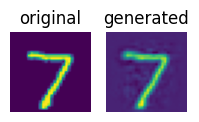

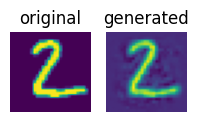

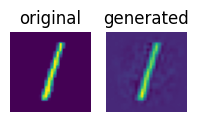

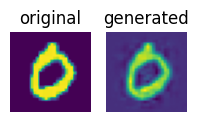

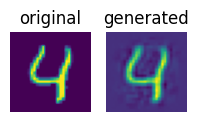

In [ ]:
from pytorch_modular.visual import plot_images
for data, lable in test_dl:
    data = data.cpu().numpy()[:5]
    preds = predictions[:5]
    for i, p in zip(data,preds):
        # first reshape both images
        i = i.reshape(28, 28)
        p = p.reshape(28, 28)
        plot_images([i, p], captions=['original', 'generated'])
    break


# SparseAutoEncoder
What if we can make the model a bit larger, with both more hidden units and layers ? This would require imposing constraints on different aspects of the model or the model's training. Thus, It is the time for the sparse auto-encoder to shine !!

In [15]:
from building_blocks import SparseAutoEncoder
from pytorch_modular.image_classification import engine_classification as engine
from torch.optim import Adam 
from torch.optim.lr_scheduler import LinearLR
from torch.nn import MSELoss

from pytorch_modular.pytorch_utilities import get_module_device
from typing import Tuple, List


model = SparseAutoEncoder(in_features=784, 
                            bottleneck=1024, 
                            num_layers=3, 
                            encoder_sparse_layers=1, 
                            decoder_sparse_layers=1, 
                            activation='relu')
# the loss associated with the sparse AE is not straightforward and thus should be written and fed to teh training functionalities

def compute_loss(model_output: Tuple[torch.Tensor, List[torch.Tensor]], 
                y: torch.Tensor,
                activation_threshold: float, 
                alpha: float, 
                epsilon: float = 10 ** -5 
                ):
    
    device = get_module_device(model)

    # first decouple the data from 
    x, activations = model_output
    # activations are expected to a list of N torch.Tensors where each element is the activations of a layer across the entire  
    mse_loss = MSELoss()(x, y)
    sparse_loss = torch.zeros(1).to(device=device)
    
    kl_loss_function = nn.KLDivLoss(reduction='batchmean').to(device=device)

    # iterate through each of the activation layers
    # we just need to compute
    

    for a in activations:
        if a.dim() != 2:
            raise ValueError((f"The activations are expected to be 1-dimensional\n"
                            f"Found: {a.dim() - 1} dimensions"))
        if not torch.all(a >= 0):
            raise ValueError(f"The activations are expected to be positive. Please make sure to use the 'ReLU' activation")
        
        # adding a small epsilon to avoid issues with log of '0'
        a = (a + epsilon).log()
        # the target should be 
        temp_loss = kl_loss_function(a, torch.full(size=a.shape, fill_value=activation_threshold).to(device=device)).abs()
        sparse_loss += temp_loss

    # divide by the number of activations
    sparse_loss /= len(activations)

    # return a linear combination of the mse_loss and sparse_loss
    return mse_loss + alpha * sparse_loss



In [16]:
import importlib
importlib.reload(engine)
# training     
# DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
optimizer = Adam(model.parameters(), lr=0.01)
scheduler = LinearLR(optimizer=optimizer, start_factor=1, end_factor=0.05, total_iters=100)

output_layer = lambda x: x
# loss_function = MSELoss().to(DEVICE)

train_configuration = {"optimizer": optimizer, 
                    'scheduler': scheduler,
                    'min_val_loss': 10 ** -4,
                    'max_epochs': 25,
                    'report_epoch': 5,
                    'metrics': {},
                    'output_layer': output_layer,
                    'compute_loss': compute_loss, 
                    'compute_loss_kwargs': {"activation_threshold": 0.05, "alpha": 0.5}
                    }

best_model, train_results = engine.train_model(model=model, 
                    train_dataloader=train_dl, 
                    test_dataloader=val_dl, 
                    train_configuration=train_configuration,
                    log_dir=os.path.join(HOME, 'runs'),
                    )

[INFO] Created SummaryWriter, saving to: /home/ayhem18/DEV/My_Kaggle_Repo/autoencoders/runs/experience_6...


  4%|▍         | 1/25 [00:01<00:32,  1.35s/it]

#########################
training loss: 8.113644894957542
validation loss : 3.1312998632589975
#########################


 24%|██▍       | 6/25 [00:07<00:24,  1.28s/it]

#########################
training loss: 0.7493347642677171
validation loss : 1.0479421007136505
#########################


 44%|████▍     | 11/25 [00:14<00:17,  1.25s/it]

#########################
training loss: 0.5526890780244554
validation loss : 1.8221179445584614
#########################


 64%|██████▍   | 16/25 [00:20<00:11,  1.29s/it]

#########################
training loss: 0.4672983116337231
validation loss : 1.2339477588733037
#########################


 84%|████████▍ | 21/25 [00:27<00:05,  1.30s/it]

#########################
training loss: 0.42769623569079807
validation loss : 0.7090456336736679
#########################


100%|██████████| 25/25 [00:32<00:00,  1.28s/it]


In [18]:
def test_iterator():
    for data, _ in test_dl:
        yield data
        
import importlib
importlib.reload(engine)
predictions = engine.inference(model, inference_source_data=test_iterator(), output_layer=lambda x: x[0])

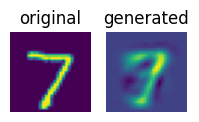

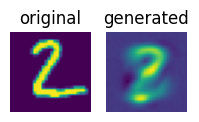

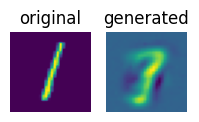

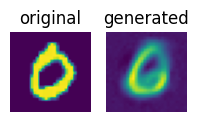

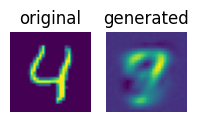

In [20]:
from pytorch_modular.visual import plot_images
for data, lable in test_dl:
    data = data.cpu().numpy()[:5]
    preds = predictions[:5]
    for i, p in zip(data,preds):
        # first reshape both images
        i = i.reshape(28, 28)
        p = p.reshape(28, 28)
        plot_images([i, p], captions=['original', 'generated'])
    break